# Inception v4

- Paper: [2016.02.23] Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning
- https://arxiv.org/abs/1602.07261

### [Package load]

In [1]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
pytorch version: 2.2.2
GPU 사용 가능 여부: False


### [Model: Inception v4]

#### Stem

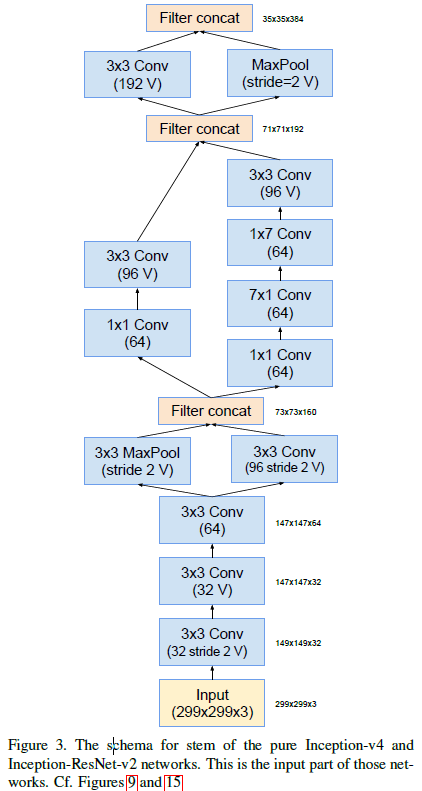

In [2]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            BasicConv2d(3, 32, kernel_size=3, stride=2, padding=0),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=0),
            BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        )
        self.branch1_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.branch1_conv = BasicConv2d(64, 96, kernel_size=3, stride=2, padding=0)

        self.branch2_a = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=0)
        )
        self.branch2_b = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 64, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 64, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=0),
        )
        self.branch3_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.branch3_conv = BasicConv2d(192, 192, kernel_size=3, stride=2, padding=0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.cat((self.branch1_pool(x),self.branch1_conv(x)),dim=1)
        x = torch.cat((self.branch2_a(x),self.branch2_b(x)),dim=1)
        x = torch.cat((self.branch3_pool(x),self.branch3_conv(x)),dim=1)
        return x

In [3]:
x = torch.randn((1, 3, 299, 299)).to(device)
model = Stem().to(device)
output_stem = model(x)
print('Input size:', x.size())
print('Stem output size:', output_stem.size())

Input size: torch.Size([1, 3, 299, 299])
Stem output size: torch.Size([1, 384, 35, 35])


#### Inception A

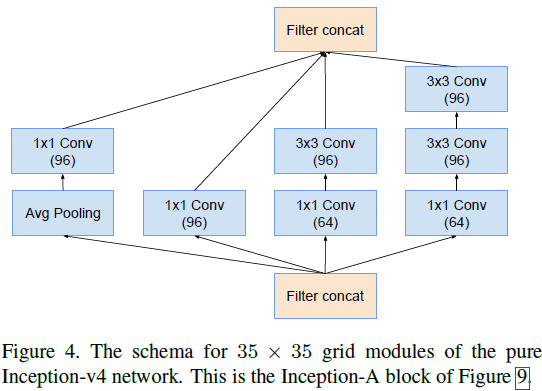

In [7]:
class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 96, kernel_size=1, stride=1, padding=0)
        )
        self.branch1x1 = BasicConv2d(in_channels, 96, kernel_size=1, stride=1, padding=0)

        self.branch3x3_a = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
        )
        self.branch3x3_b = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1),
        )
        
    def forward(self, x):
        x = torch.cat((self.branch_pool(x),self.branch1x1(x), self.branch3x3_a(x), self.branch3x3_b(x)),dim=1)
        return x

In [12]:
model = InceptionA(output_stem.size(1)).to(device)
output_a = model(output_stem)
print('Stem output size:', output_stem.size())
print('Inception A output size:', output_a.size())

Stem output size: torch.Size([1, 384, 35, 35])
Inception A output size: torch.Size([1, 384, 35, 35])


#### Reduction A

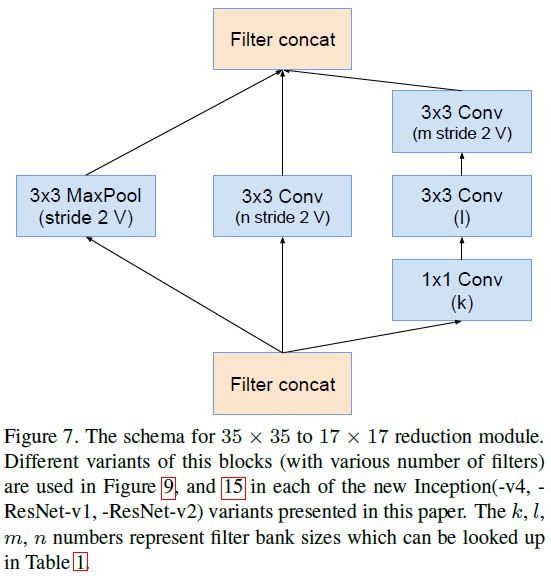

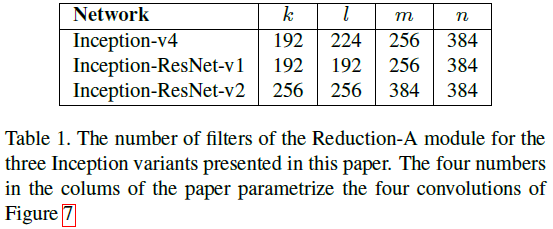

In [9]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super().__init__()
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.branch_conv = BasicConv2d(in_channels, n, kernel_size=3, stride=2, padding=0)
        self.branch_convs = nn.Sequential(
            BasicConv2d(in_channels, k, kernel_size=1, stride=1, padding=0),
            BasicConv2d(k, l, kernel_size=3, stride=1, padding=1),
            BasicConv2d(l, m, kernel_size=3, stride=2, padding=0)
        )
    def forward(self, x):
        x = torch.cat((self.branch_pool(x),self.branch_conv(x), self.branch_convs(x)),dim=1)
        return x

In [15]:
model = ReductionA(output_a.size(1), 192, 224, 256, 384).to(device)
output_reduction_a = model(output_a)
print('Inception A output size:', output_a.size())
print('Reduction A output size:', output_reduction_a.size())

Inception A output size: torch.Size([1, 384, 35, 35])
Reduction A output size: torch.Size([1, 1024, 17, 17])


#### Inception B

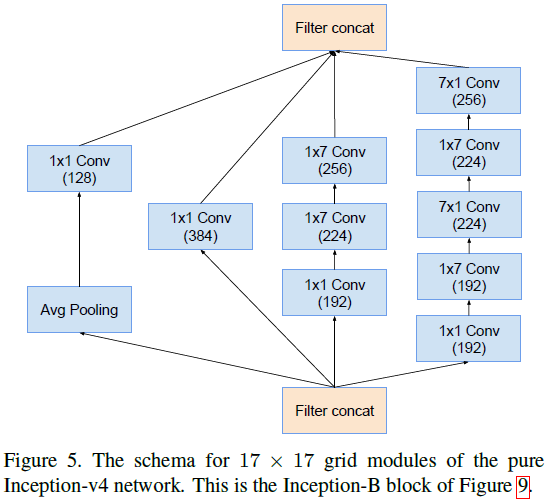

In [11]:
class InceptionB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        )        
        self.branch1x1 = BasicConv2d(in_channels, 384, kernel_size=1, stride=1, padding=0)
        self.branch7x7_a = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0))
        )
        self.branch7x7_b = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(192, 224, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(224, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0))
        )
    
    def forward(self, x):
        x = torch.cat((self.branch_pool(x), self.branch1x1(x), self.branch7x7_a(x), self.branch7x7_b(x)),dim=1)
        return x

In [13]:
model = InceptionB(output_reduction_a.size(1)).to(device)
output_b = model(output_reduction_a)
print('Reduction A output size:', output_reduction_a.size())
print('Inception B output size:', output_b.size())

Reduction A output size: torch.Size([1, 1024, 17, 17])
Inception B output size: torch.Size([1, 1024, 17, 17])


#### Reduction B

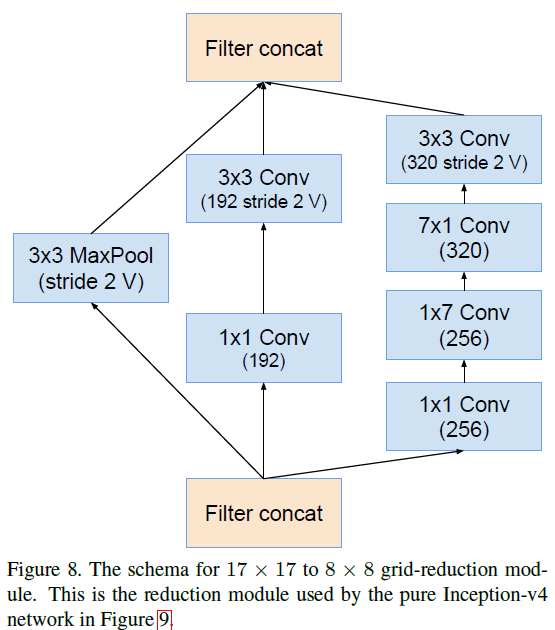

In [18]:
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.branch_conv_a = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, stride=1, padding=0),
            BasicConv2d(192, 192, kernel_size=3, stride=2, padding=0)
        )
        self.branch_conv_b = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(256, 320, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(320, 320, kernel_size=3, stride=2, padding=0)
        )
    def forward(self, x):
        x = torch.cat((self.branch_pool(x), self.branch_conv_a(x), self.branch_conv_b(x)), dim=1)
        return x

In [19]:
model = ReductionB(output_b.size(1)).to(device)
output_reduction_b = model(output_b)
print('Inception B output size:', output_b.size())
print('Reduction B output size:', output_reduction_b.size())

Inception B output size: torch.Size([1, 1024, 17, 17])
Reduction B output size: torch.Size([1, 1536, 8, 8])


#### Inception C

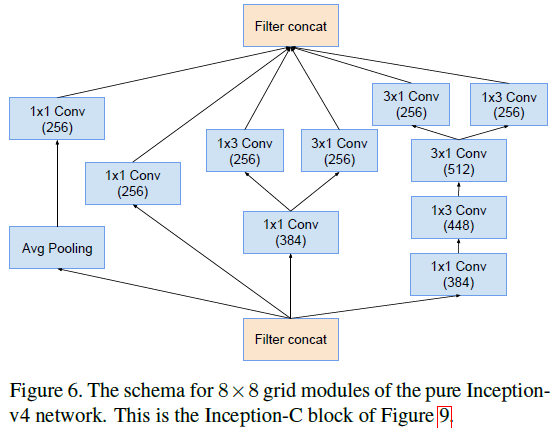

In [24]:
class InceptionC(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)
        )

        self.branch1x1 = BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)

        self.branch3x3_a_0 = BasicConv2d(in_channels, 384, kernel_size=1, stride=1, padding=0)
        self.branch3x3_a_1 = BasicConv2d(384, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch3x3_a_2 = BasicConv2d(384, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        
        self.branch3x3_b_0 = nn.Sequential(
            BasicConv2d(in_channels, 384, kernel_size=1, stride=1),
            BasicConv2d(384, 448, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(448, 512, kernel_size=(3,1), stride=1, padding=(1,0))
        )
        self.branch3x3_b_1 = BasicConv2d(512, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch3x3_b_2 = BasicConv2d(512, 256, kernel_size=(3,1), stride=1, padding=(1,0)) 
    
    def forward(self, x):
        x_branch3x3_a_0 = self.branch3x3_a_0(x)
        x_branch3x3_b_0 = self.branch3x3_b_0(x)
        x = torch.cat((self.branch_pool(x),self.branch1x1(x), self.branch3x3_a_1(x_branch3x3_a_0), self.branch3x3_a_2(x_branch3x3_a_0),
                       self.branch3x3_b_1(x_branch3x3_b_0),self.branch3x3_b_2(x_branch3x3_b_0)),dim=1)
        return x

In [26]:
model = InceptionC(output_reduction_b.size(1)).to(device)
output_c = model(output_reduction_b)
print('Reduction B output size:', output_reduction_b.size())
print('Inception ResNet C output size:', output_c.size())

Reduction B output size: torch.Size([1, 1536, 8, 8])
Inception ResNet C output size: torch.Size([1, 1536, 8, 8])


#### Inception V4

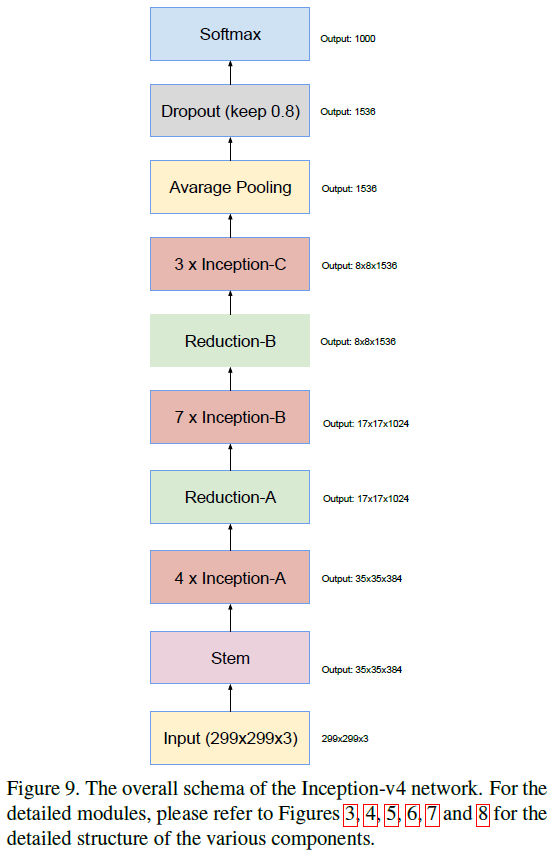

In [27]:
class InceptionV4(nn.Module):
    def __init__(self, A, B, C, k=192, l=224, m=256, n=384, num_classes=1000, init_weights=True):
        super().__init__()
        blocks = list()
        blocks.append(Stem())
        for i in range(A):
            blocks.append(InceptionA(384))   # Scaling factor는 왜 이 숫자인지 잘 모르겠음
        blocks.append(ReductionA(384, k, l, m, n))
        for i in range(B):
            blocks.append(InceptionB(1024))
        blocks.append(ReductionB(1024))
        for i in range(C):
            blocks.append(InceptionC(1536))
        
        self.features = nn.Sequential(*blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # (1, 1536, 8, 8) -> (1, 1536, 1, 1)
        self.dropout = nn.Dropout(0.2)    # Drop out, keep 0.8이므로 0.2를 넣음
        self.linear = nn.Linear(1536, num_classes)
        
        if init_weights:
            self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)   # Flatten 시키기
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [28]:
inception_v4 = InceptionV4(A=4, B=7, C=3)

In [29]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 299, 299)))
inception_v4(temp).size()

torch.Size([1, 1000])

In [30]:
from torchsummary import summary
summary(inception_v4, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 96, 73, 73]          55,296
      BatchNorm2d-12           [-1, 96, 73, 73]             192
      BasicConv2d-13           [-1, 96, 73, 73]               0
           Conv2d-14           [-1, 64,

In [31]:
from torchinfo import summary
summary(inception_v4, input_size=(1, 3, 299, 299), col_width=20, depth=100, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                  Input Shape          Kernel Shape         Output Shape         Param %
InceptionV4 (InceptionV4)                          [1, 3, 299, 299]     --                   [1, 1000]                 --
├─Sequential (features): 1-1                       [1, 3, 299, 299]     --                   [1, 1536, 8, 8]           --
│    └─Stem (0): 2-1                               [1, 3, 299, 299]     --                   [1, 384, 35, 35]          --
│    │    └─Sequential (conv1): 3-1                [1, 3, 299, 299]     --                   [1, 64, 147, 147]         --
│    │    │    └─BasicConv2d (0): 4-1              [1, 3, 299, 299]     --                   [1, 32, 149, 149]         --
│    │    │    │    └─Conv2d (conv): 5-1           [1, 3, 299, 299]     [3, 3]               [1, 32, 149, 149]      0.00%
│    │    │    │    └─BatchNorm2d (bn): 5-2        [1, 32, 149, 149]    --                   [1, 32, 149, 149]      0.00%
│    │    │    └─BasicCo